In [27]:
import numpy as np
import pandas as pd
from mne import create_info
from mne.io import RawArray
import matplotlib.pyplot as plt
from mne.channels.montage import make_standard_montage
from mne.time_frequency import stft
from mne.baseline import rescale
from mne.datasets import somato
from mne.stats import bootstrap_confidence_interval

In [22]:
path = "../../Datasets/initialData.csv"

[    0     1     2 ... 23687 23688 23689] [1. 1. 1. ... 1. 1. 1.]
stim_data =  [[1. 1. 1. ... 1. 1. 1.]]


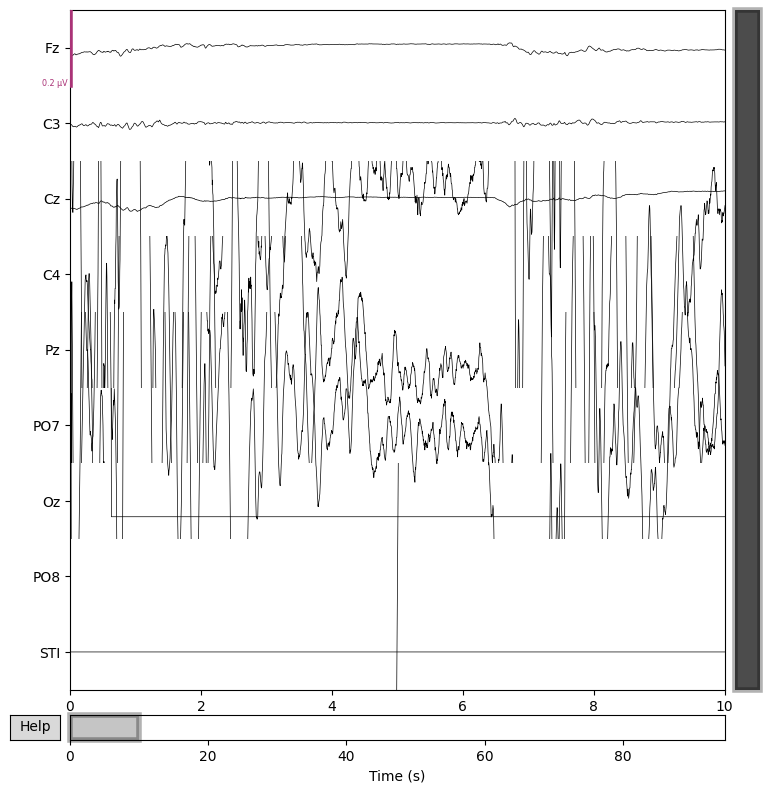

In [23]:
chs = ["Fz", "C3", "Cz", "C4", "Pz", "PO7", "Oz", "PO8"]
df = pd.read_csv(path, names=chs +["STIM"]) #use STIM only if you have a trigger
trigger = np.array(df.STIM)
eeg = df.iloc[:, 0:8].to_numpy()
fs = 250

amplify = 1e7 # amplification factor 
recompute = False # wether if changing trigger numerical values or not to avoid Event "0"

thisRec = RawArray(eeg.T/amplify, create_info(chs, fs, ch_types='eeg'))

# Get event indexes where value is not 0, i.e. -1 or 1
pos = np.nonzero(trigger)[0]

# Filter 0 values from the trigger array
y = trigger[trigger != 0]
print(pos, y)

# Create the stimuli channel
stim_data = np.zeros((1,thisRec.n_times))

# MNE works with absolute values of labels so -1 and +1 would result in only one kind of event
# that's why we add 2 and obtain 1 and 3 as label values
stim_data[0,pos] = (y + 2) if recompute else  y

print('stim_data = ', stim_data)
stim_raw = RawArray(stim_data, create_info(['STI'], thisRec.info['sfreq'], ch_types=['stim']))

# adding the stimuli channel (as a Raw object) to our EEG Raw object
thisRec.add_channels([stim_raw])

# Set the standard 10-20 montage
montage = make_standard_montage('standard_1020')
thisRec.set_montage(montage)

# Plot with adjusted scale (e.g., 1e-4 for EEG channels)
thisRec.plot(scalings={'eeg': 1e-7})
plt.show()

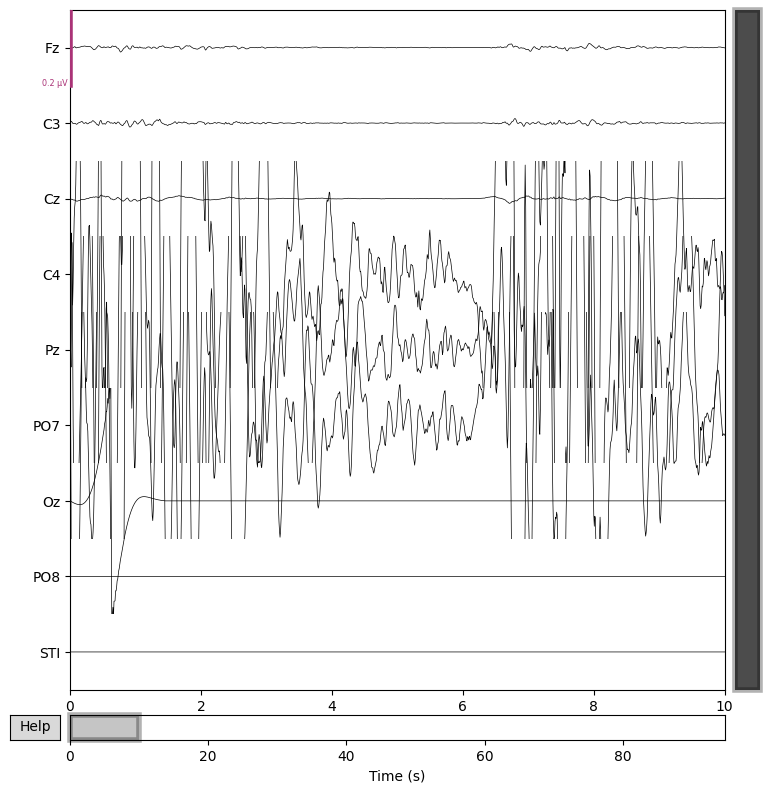

In [24]:
# Filter the data using a bandpass filter from 2 to 40 Hz 
thisRec.filter(2, 40)

# Filter the data using a notch filter at 50 Hz
thisRec.notch_filter(50)

# Plot the data again
thisRec.plot(scalings={'eeg': 1e-7})
plt.show()

In [33]:
import mne

# Find events in the "STI" channel
events = mne.find_events(thisRec, stim_channel='STI')
event_id = 1
tmin = -1.0  # Define the start time of each epoch relative to the event (in seconds)
tmax = 3.0   # Define the end time of each epoch relative to the event (in seconds)
baseline = None  # No baseline correction for now, you can adjust if needed


# Frequency bands of interest
iter_freqs = [("Theta", 4, 7), ("Alpha", 8, 12), ("Beta", 13, 25), ("Gamma", 30, 45)]

frequency_map = list()

for band, fmin, fmax in iter_freqs:
    # (re)load the data to save memory
    raw_copy = thisRec.copy()
    raw_copy.pick(picks=["eeg"])  # Assuming you want to analyze only EEG channels
    raw_copy.load_data()

    # bandpass filter
    raw_copy.filter(
        fmin,
        fmax,
        n_jobs=None,  # use more jobs to speed up.
        l_trans_bandwidth=1,  # make sure filter params are the same
        h_trans_bandwidth=1,
    )  # in each band and skip "auto" option.

    # epoch
    epochs = mne.Epochs(
        raw_copy,
        events,
        event_id,
        tmin,
        tmax,
        baseline=baseline,
        reject=dict(eeg=4000e-13),
        preload=True,
    )
    
    # remove evoked response
    epochs.subtract_evoked()

    # get analytic signal (envelope)
    epochs.apply_hilbert(envelope=True)
    
    # append to frequency_map
    frequency_map.append(((band, fmin, fmax), epochs.average()))
    
    del epochs

# rest of the code for plotting


ValueError: No matching events found for 1 (event id 1)

In [ ]:
# Helper function for plotting spread
def stat_fun(x):
    """Return sum of squares."""
    return np.sum(x**2, axis=0)


# Plot
fig, axes = plt.subplots(4, 1, figsize=(10, 7), sharex=True, sharey=True)
colors = plt.colormaps["winter_r"](np.linspace(0, 1, 4))
for ((freq_name, fmin, fmax), average), color, ax in zip(
    frequency_map, colors, axes.ravel()[::-1]
):
    times = average.times * 1e3
    gfp = np.sum(average.data**2, axis=0)
    gfp = mne.baseline.rescale(gfp, times, baseline=(None, 0))
    ax.plot(times, gfp, label=freq_name, color=color, linewidth=2.5)
    ax.axhline(0, linestyle="--", color="grey", linewidth=2)
    ci_low, ci_up = bootstrap_confidence_interval(
        average.data, random_state=0, stat_fun=stat_fun
    )
    ci_low = rescale(ci_low, average.times, baseline=(None, 0))
    ci_up = rescale(ci_up, average.times, baseline=(None, 0))
    ax.fill_between(times, gfp + ci_up, gfp - ci_low, color=color, alpha=0.3)
    ax.grid(True)
    ax.set_ylabel("GFP")
    ax.annotate(
        "%s (%d-%dHz)" % (freq_name, fmin, fmax),
        xy=(0.95, 0.8),
        horizontalalignment="right",
        xycoords="axes fraction",
    )
    ax.set_xlim(-1000, 3000)

axes.ravel()[-1].set_xlabel("Time [ms]")